## Load libraries

In [4]:
%load_ext autoreload
%autoreload 2


In [5]:
import numpy as np
import numba as nb
import pandas as pd
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mpmath as mp
from matplotlib.transforms import Bbox
from InitCondPOHomogeous import InitCondPOHomogeneous
from InitPO_2 import InitCondPOHomogeneous_2
from NextGenPopModel import NextGenPopModel
import cv2
from PIL import Image
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D


## Load spatial distribution data

## Reorder

In [6]:
# Load your .dat file — adjust the separator (e.g. whitespace, comma, etc.)
df = pd.read_csv('aal.dat', delim_whitespace=True, header=None)  # or use sep=',' or sep='\t'

# Assume the label column is the last one
label_col = 6

# Split the dataframe into 'L' and 'R' groups
df_L = df[df[label_col] == 'L'].iloc[::-1]  # reverse the order
df_R = df[df[label_col] == 'R']            # keep as is

# Concatenate back: L first (reversed), then R
df_sorted = pd.concat([df_R, df_L], ignore_index=True)

# (Optional) Relabel index column
df_sorted.iloc[:, 0] = range(len(df_sorted))

# Save
df_sorted.to_csv('Sorted_aal.dat', sep='\t', index=False, header=False)

/var/folders/bk/8psdzd0d5r33yt6wq9ycyh3h0000gn/T/ipykernel_19476/3804671514.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('aal.dat', delim_whitespace=True, header=None)  # or use sep=',' or sep='\t'


In [7]:
df

,0,1,2,3,4,5,6,7
0,#,name,x.mni,y.mni,z.mni,lobe,hemi,index
1,1,PreCG.L,-38.65,-5.68,50.94,Frontal,L,1
2,2,PreCG.R,41.37,-8.21,52.09,Frontal,R,2
3,3,SFGdor.L,-18.45,34.81,42.20,Frontal,L,3
4,4,SFGdor.R,21.90,31.12,43.82,Frontal,R,4
...,...,...,...,...,...,...,...,...
86,86,MTG.R,57.47,-37.23,-1.47,Temporal,R,86
87,87,TPOmid.L,-36.32,14.59,-34.08,Temporal,L,87
88,88,TPOmid.R,44.22,14.55,-32.23,Temporal,R,88
89,89,ITG.L,-49.77,-28.05,-23.17,Temporal,L,89


In [8]:
df_L

,0,1,2,3,4,5,6,7
89,89,ITG.L,-49.77,-28.05,-23.17,Temporal,L,89
87,87,TPOmid.L,-36.32,14.59,-34.08,Temporal,L,87
85,85,MTG.L,-55.52,-33.80,-2.20,Temporal,L,85
83,83,TPOsup.L,-39.88,15.14,-20.18,Temporal,L,83
81,81,STG.L,-53.16,-20.68,7.13,Temporal,L,81
79,79,HES.L,-41.99,-18.88,9.98,Temporal,L,79
77,77,THA.L,-10.85,-17.56,7.98,SCGM,L,77
75,75,PAL.L,-17.75,-0.03,0.21,SCGM,L,75
73,73,PUT.L,-23.91,3.86,2.40,SCGM,L,73
71,71,CAU.L,-11.46,11.00,9.24,SCGM,L,71


In [9]:
df_R

,0,1,2,3,4,5,6,7
2,2,PreCG.R,41.37,-8.21,52.09,Frontal,R,2
4,4,SFGdor.R,21.90,31.12,43.82,Frontal,R,4
6,6,ORBsup.R,18.49,48.10,-14.02,Frontal,R,6
8,8,MFG.R,37.59,33.06,34.04,Frontal,R,8
10,10,ORBmid.R,33.18,52.59,-10.73,Frontal,R,10
12,12,IFGoperc.R,50.20,14.98,21.41,Frontal,R,12
14,14,IFGtriang.R,50.33,30.16,14.17,Frontal,R,14
16,16,ORBinf.R,41.22,32.23,-11.91,Frontal,R,16
18,18,ROL.R,52.65,-6.25,14.63,Frontal,R,18
20,20,SMA.R,8.62,0.17,61.85,Frontal,R,20


In [10]:
df_sorted

,0,1,2,3,4,5,6,7
0,0,PreCG.R,41.37,-8.21,52.09,Frontal,R,2
1,1,SFGdor.R,21.90,31.12,43.82,Frontal,R,4
2,2,ORBsup.R,18.49,48.10,-14.02,Frontal,R,6
3,3,MFG.R,37.59,33.06,34.04,Frontal,R,8
4,4,ORBmid.R,33.18,52.59,-10.73,Frontal,R,10
...,...,...,...,...,...,...,...,...
85,85,ORBmid.L,-30.65,50.43,-9.62,Frontal,L,9
86,86,MFG.L,-33.43,32.73,35.46,Frontal,L,7
87,87,ORBsup.L,-16.56,47.32,-13.31,Frontal,L,5
88,88,SFGdor.L,-18.45,34.81,42.20,Frontal,L,3


## No executar aquesta part

In [30]:
with open("aal.dat", "r") as f:
    lines = f.readlines()

# Sort with custom key: lines ending in 'L' come first
lines_sorted = sorted(lines, key=lambda line: 0 if line.strip().endswith('L') else 1)

with open("Sort_aal.dat", "w") as f:
    f.writelines(lines_sorted)

In [39]:
lines_sorted

['#          name  x.mni  y.mni  z.mni      lobe hemi index\n',
 '1      PreCG.L -38.65  -5.68  50.94   Frontal    L     1\n',
 '2      PreCG.R  41.37  -8.21  52.09   Frontal    R     2\n',
 '3     SFGdor.L -18.45  34.81  42.20   Frontal    L     3\n',
 '4     SFGdor.R  21.90  31.12  43.82   Frontal    R     4\n',
 '5     ORBsup.L -16.56  47.32 -13.31   Frontal    L     5\n',
 '6     ORBsup.R  18.49  48.10 -14.02   Frontal    R     6\n',
 '7        MFG.L -33.43  32.73  35.46   Frontal    L     7\n',
 '8        MFG.R  37.59  33.06  34.04   Frontal    R     8\n',
 '9     ORBmid.L -30.65  50.43  -9.62   Frontal    L     9\n',
 '10    ORBmid.R  33.18  52.59 -10.73   Frontal    R    10\n',
 '11  IFGoperc.L -48.43  12.73  19.02   Frontal    L    11\n',
 '12  IFGoperc.R  50.20  14.98  21.41   Frontal    R    12\n',
 '13 IFGtriang.L -45.58  29.91  13.99   Frontal    L    13\n',
 '14 IFGtriang.R  50.33  30.16  14.17   Frontal    R    14\n',
 '15    ORBinf.L -35.98  30.71 -12.11   Frontal    L  

In [96]:
import pandas as pd

# Load your .dat file — adjust the separator (e.g. whitespace, comma, etc.)
df = pd.read_csv('aal.dat', delim_whitespace=True, header=None)  # or use sep=',' or sep='\t'

# Let's say the column with 'L' or 'R' is column 3 (0-based index). Adjust as needed.
col_with_LR = 6

# Sort so that 'L' rows come first
df_sorted = df.sort_values(by=col_with_LR, key=lambda col: col.map({'L': 1, 'R': 0}),kind='stable')
# Replace the first column (column 0) with sequential integers
df_sorted.iloc[:, 0] = range(len(df_sorted))

# Save the sorted file
df_sorted.to_csv('Sort_aal.dat', sep='\t', index=False, header=False)


/var/folders/bk/8psdzd0d5r33yt6wq9ycyh3h0000gn/T/ipykernel_9911/3923823342.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('aal.dat', delim_whitespace=True, header=None)  # or use sep=',' or sep='\t'


In [97]:
df

,0,1,2,3,4,5,6,7
0,#,name,x.mni,y.mni,z.mni,lobe,hemi,index
1,1,PreCG.L,-38.65,-5.68,50.94,Frontal,L,1
2,2,PreCG.R,41.37,-8.21,52.09,Frontal,R,2
3,3,SFGdor.L,-18.45,34.81,42.20,Frontal,L,3
4,4,SFGdor.R,21.90,31.12,43.82,Frontal,R,4
...,...,...,...,...,...,...,...,...
86,86,MTG.R,57.47,-37.23,-1.47,Temporal,R,86
87,87,TPOmid.L,-36.32,14.59,-34.08,Temporal,L,87
88,88,TPOmid.R,44.22,14.55,-32.23,Temporal,R,88
89,89,ITG.L,-49.77,-28.05,-23.17,Temporal,L,89


In [133]:
df_sorted

,0,1,2,3,4,5,6,7
0,0,ITG.L,-49.77,-28.05,-23.17,Temporal,L,89
1,1,TPOmid.L,-36.32,14.59,-34.08,Temporal,L,87
2,2,MTG.L,-55.52,-33.80,-2.20,Temporal,L,85
3,3,TPOsup.L,-39.88,15.14,-20.18,Temporal,L,83
4,4,STG.L,-53.16,-20.68,7.13,Temporal,L,81
...,...,...,...,...,...,...,...,...
85,85,STG.R,58.15,-21.78,6.80,Temporal,R,82
86,86,TPOsup.R,48.25,14.75,-16.86,Temporal,R,84
87,87,MTG.R,57.47,-37.23,-1.47,Temporal,R,86
88,88,TPOmid.R,44.22,14.55,-32.23,Temporal,R,88


In [99]:
# Open the .dat file and read the first few lines to inspect the structure
with open('Sort_aal.dat', 'r') as file:
    for i in range(90):  # Read the first 5 lines
        print(file.readline())

0	PreCG.R	41.37	-8.21	52.09	Frontal	R	2

1	SFGdor.R	21.90	31.12	43.82	Frontal	R	4

2	ORBsup.R	18.49	48.10	-14.02	Frontal	R	6

3	MFG.R	37.59	33.06	34.04	Frontal	R	8

4	ORBmid.R	33.18	52.59	-10.73	Frontal	R	10

5	IFGoperc.R	50.20	14.98	21.41	Frontal	R	12

6	IFGtriang.R	50.33	30.16	14.17	Frontal	R	14

7	ORBinf.R	41.22	32.23	-11.91	Frontal	R	16

8	ROL.R	52.65	-6.25	14.63	Frontal	R	18

9	SMA.R	8.62	0.17	61.85	Frontal	R	20

10	OLF.R	10.43	15.91	-11.26	Frontal	R	22

11	SFGmed.R	9.10	50.84	30.22	Frontal	R	24

12	ORBsupmed.R	8.16	51.67	-7.13	Frontal	R	26

13	REC.R	8.35	35.64	-18.04	Frontal	R	28

14	INS.R	39.02	6.25	2.08	Insula	R	30

15	ACG.R	8.46	37.01	15.84	Limbic	R	32

16	DCG.R	8.02	-8.83	39.79	Limbic	R	34

17	PCG.R	7.44	-41.81	21.87	Limbic	R	36

18	HIP.R	29.23	-19.78	-10.33	Limbic	R	38

19	PHG.R	25.38	-15.15	-20.47	Limbic	R	40

20	AMYG.R	27.32	0.64	-17.50	Limbic	R	42

21	CAL.R	15.99	-73.15	9.40	Occipital	R	44

22	CUN.R	13.51	-79.36	28.23	Occipital	R	46

23	LING.R	16.29	-66.93	-3.87	Occipital

## Load Sorted data

In [11]:
# Read .dat file
# Define the structured dtype
#dtype = [('col0', float), ('col1', 'U1'), ('col2', float), ('col3', float), ('col4', float), ('col5', 'U1'), ('col6', 'U1'),('col7', float)] 
SpatialDistribSort = np.genfromtxt('Sorted_aal.dat', delimiter='\t', encoding=None,usecols=(0, 2, 3, 4,7))

# Show data
print(SpatialDistribSort)

[[ 0.000e+00  4.137e+01 -8.210e+00  5.209e+01  2.000e+00]
 [ 1.000e+00  2.190e+01  3.112e+01  4.382e+01  4.000e+00]
 [ 2.000e+00  1.849e+01  4.810e+01 -1.402e+01  6.000e+00]
 [ 3.000e+00  3.759e+01  3.306e+01  3.404e+01  8.000e+00]
 [ 4.000e+00  3.318e+01  5.259e+01 -1.073e+01  1.000e+01]
 [ 5.000e+00  5.020e+01  1.498e+01  2.141e+01  1.200e+01]
 [ 6.000e+00  5.033e+01  3.016e+01  1.417e+01  1.400e+01]
 [ 7.000e+00  4.122e+01  3.223e+01 -1.191e+01  1.600e+01]
 [ 8.000e+00  5.265e+01 -6.250e+00  1.463e+01  1.800e+01]
 [ 9.000e+00  8.620e+00  1.700e-01  6.185e+01  2.000e+01]
 [ 1.000e+01  1.043e+01  1.591e+01 -1.126e+01  2.200e+01]
 [ 1.100e+01  9.100e+00  5.084e+01  3.022e+01  2.400e+01]
 [ 1.200e+01  8.160e+00  5.167e+01 -7.130e+00  2.600e+01]
 [ 1.300e+01  8.350e+00  3.564e+01 -1.804e+01  2.800e+01]
 [ 1.400e+01  3.902e+01  6.250e+00  2.080e+00  3.000e+01]
 [ 1.500e+01  8.460e+00  3.701e+01  1.584e+01  3.200e+01]
 [ 1.600e+01  8.020e+00 -8.830e+00  3.979e+01  3.400e+01]
 [ 1.700e+01  

In [10]:
SpatialDistribSort.shape

(90, 5)

In [11]:
time = 925
#%matplotlib qt
%matplotlib inline  
# Define colors
colors = veps[:,0]
# Set a fixed size for all points (e.g., 20)
point_size = 400
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

my_plot = ax.scatter(SpatialDistribSort[:, 1], SpatialDistribSort[:, 2], SpatialDistribSort[:, 3], 
                     c=colors, s=point_size, cmap='bwr', vmin=-0.2, vmax=0.2)
#my_plot = ax.scatter(SpatialDistrib[:, 0], np.transpose(SpatialDistrib[:, 1]), np.transpose(SpatialDistrib[:, 2]), 
                     #c=colors, s=point_size, cmap='bwr', vmin=-0.2, vmax=0.2)
# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.set_title(r'$\epsilon = $' + str(ParametersPop['eps']) + r', $I_{ext}^e = $' + str(ParametersPop['Iext_e']),fontsize=20,fontname='Times New Roman')

# Hide the grid and axes
ax.grid(False)
ax.set_axis_off()

# Add a colorbar linked to the scatter plot
cbar = plt.colorbar(my_plot, ax=ax,fraction=0.03,pad=0.01)
cbar.set_label(r'$v_{E,i}$', fontsize=20,fontname='Times New Roman')
cbar.ax.tick_params(labelsize=20)

# Rotate the plot: Set the elevation (elev) and azimuth (azim)
ax.view_init(elev=90, azim=90)

NameError: name 'veps' is not defined

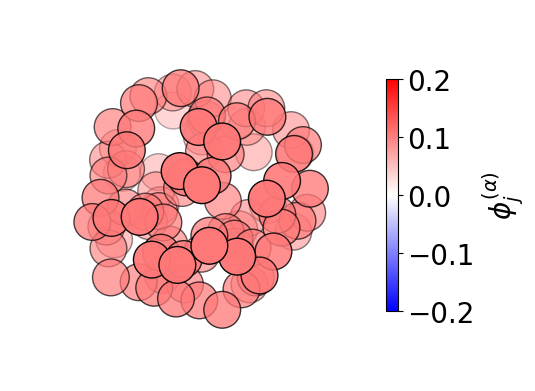

In [ ]:
time = 925
#%matplotlib qt
%matplotlib inline  
# Define colors
colors = veps[:,0]
# Set a fixed size for all points (e.g., 20)
point_size = 700
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

my_plot = ax.scatter(SpatialDistribSort[:, 1], SpatialDistribSort[:, 2], SpatialDistribSort[:, 3], 
                     c=colors, s=point_size, facecolors = colors, edgecolors='black',cmap='bwr', vmin=-0.2, vmax=0.2)
#my_plot = ax.scatter(SpatialDistrib[:, 0], np.transpose(SpatialDistrib[:, 1]), np.transpose(SpatialDistrib[:, 2]), 
                     #c=colors, s=point_size, cmap='bwr', vmin=-0.2, vmax=0.2)
# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.set_title(r'$\epsilon = $' + str(ParametersPop['eps']) + r', $I_{ext}^e = $' + str(ParametersPop['Iext_e']),fontsize=20,fontname='Times New Roman')

# Hide the grid and axes
ax.grid(False)
ax.set_axis_off()

# Add a colorbar linked to the scatter plot
cbar = plt.colorbar(my_plot, ax=ax,fraction=0.03,pad=0.01)
cbar.set_label(r'$\phi_j^{(\alpha)}$', fontsize=20,fontname='Times New Roman')
cbar.ax.tick_params(labelsize=20)

# Rotate the plot: Set the elevation (elev) and azimuth (azim)
ax.view_init(elev=0, azim=110)
plt.savefig('Definitive/Brain.png',dpi=500,bbox_inches=Bbox([[0,-1],fig.get_size_inches()]))

Text(0.5, 0.92, '3D Scatter Plot')

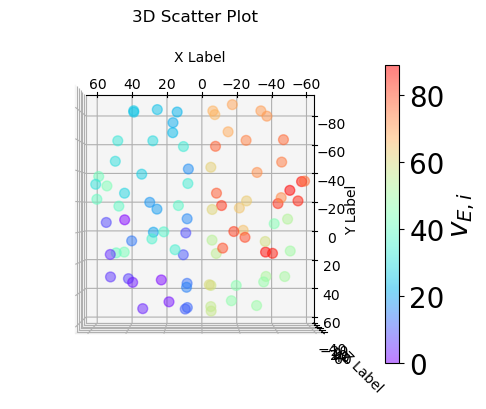

In [143]:
# Define colors
colors = np.random.rand(90)
# Set a fixed size for all points (e.g., 20)
point_size = 20
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
#my_plot = ax.scatter(SpatialDistrib[0:5,0],SpatialDistrib[0:5,1],SpatialDistrib[0:5,2],c=SpatialDistrib[0:5,3], cmap='rainbow',s=50,alpha=0.5)
my_plot = ax.scatter(SpatialDistribSort[:,1],SpatialDistribSort[:,2],SpatialDistribSort[:,3],c=SpatialDistribSort[:,0], cmap='rainbow',s=50,alpha=0.5)

# Labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Rotate the plot: Set the elevation (elev) and azimuth (azim)
ax.view_init(elev=90, azim=90)

# Add a colorbar linked to the scatter plot
cbar = plt.colorbar(my_plot, ax=ax,fraction=0.03,pad=0.01)
cbar.set_label(r'$v_{E,i}$', fontsize=20,fontname='Times New Roman')
cbar.ax.tick_params(labelsize=20)

# Hide the grid
#ax.grid(False)

# Hide the axes
#ax.set_axis_off()

# Add title
ax.set_title('3D Scatter Plot')
#plt.show()

### First access the data to discover its structure

In [3]:
# Open the .dat file and read the first few lines to inspect the structure
with open('aal.dat', 'r') as file:
    for i in range(91):  # Read the first 5 lines
        print(file.readline())

#          name  x.mni  y.mni  z.mni      lobe hemi index

1      PreCG.L -38.65  -5.68  50.94   Frontal    L     1

2      PreCG.R  41.37  -8.21  52.09   Frontal    R     2

3     SFGdor.L -18.45  34.81  42.20   Frontal    L     3

4     SFGdor.R  21.90  31.12  43.82   Frontal    R     4

5     ORBsup.L -16.56  47.32 -13.31   Frontal    L     5

6     ORBsup.R  18.49  48.10 -14.02   Frontal    R     6

7        MFG.L -33.43  32.73  35.46   Frontal    L     7

8        MFG.R  37.59  33.06  34.04   Frontal    R     8

9     ORBmid.L -30.65  50.43  -9.62   Frontal    L     9

10    ORBmid.R  33.18  52.59 -10.73   Frontal    R    10

11  IFGoperc.L -48.43  12.73  19.02   Frontal    L    11

12  IFGoperc.R  50.20  14.98  21.41   Frontal    R    12

13 IFGtriang.L -45.58  29.91  13.99   Frontal    L    13

14 IFGtriang.R  50.33  30.16  14.17   Frontal    R    14

15    ORBinf.L -35.98  30.71 -12.11   Frontal    L    15

16    ORBinf.R  41.22  32.23 -11.91   Frontal    R    16

17       ROL.

### Read only the columns that contain the x, y, z position of the population

In [4]:
# Read .dat file
SpatialDistrib = np.genfromtxt('aal.dat', delimiter=None, skip_header=1, usecols=(2, 3, 4,7))

# Show data
print(SpatialDistrib)

[[-3.865e+01 -5.680e+00  5.094e+01  1.000e+00]
 [ 4.137e+01 -8.210e+00  5.209e+01  2.000e+00]
 [-1.845e+01  3.481e+01  4.220e+01  3.000e+00]
 [ 2.190e+01  3.112e+01  4.382e+01  4.000e+00]
 [-1.656e+01  4.732e+01 -1.331e+01  5.000e+00]
 [ 1.849e+01  4.810e+01 -1.402e+01  6.000e+00]
 [-3.343e+01  3.273e+01  3.546e+01  7.000e+00]
 [ 3.759e+01  3.306e+01  3.404e+01  8.000e+00]
 [-3.065e+01  5.043e+01 -9.620e+00  9.000e+00]
 [ 3.318e+01  5.259e+01 -1.073e+01  1.000e+01]
 [-4.843e+01  1.273e+01  1.902e+01  1.100e+01]
 [ 5.020e+01  1.498e+01  2.141e+01  1.200e+01]
 [-4.558e+01  2.991e+01  1.399e+01  1.300e+01]
 [ 5.033e+01  3.016e+01  1.417e+01  1.400e+01]
 [-3.598e+01  3.071e+01 -1.211e+01  1.500e+01]
 [ 4.122e+01  3.223e+01 -1.191e+01  1.600e+01]
 [-4.716e+01 -8.480e+00  1.395e+01  1.700e+01]
 [ 5.265e+01 -6.250e+00  1.463e+01  1.800e+01]
 [-5.320e+00  4.850e+00  6.138e+01  1.900e+01]
 [ 8.620e+00  1.700e-01  6.185e+01  2.000e+01]
 [-8.060e+00  1.505e+01 -1.146e+01  2.100e+01]
 [ 1.043e+01 

In [5]:
SpatialDistrib.shape

(90, 4)

In [6]:
SpatialDistrib[:,0]

array([-38.65,  41.37, -18.45,  21.9 , -16.56,  18.49, -33.43,  37.59,
       -30.65,  33.18, -48.43,  50.2 , -45.58,  50.33, -35.98,  41.22,
       -47.16,  52.65,  -5.32,   8.62,  -8.06,  10.43,  -4.8 ,   9.1 ,
        -5.17,   8.16,  -5.08,   8.35, -35.13,  39.02,  -4.04,   8.46,
        -5.48,   8.02,  -4.85,   7.44, -25.03,  29.23, -21.17,  25.38,
       -23.27,  27.32,  -7.14,  15.99,  -5.93,  13.51, -14.62,  16.29,
       -16.54,  24.29, -32.39,  37.39, -36.36,  38.16, -31.16,  33.97,
       -42.46,  41.43, -23.45,  26.11, -42.8 ,  46.46, -55.79,  57.61,
       -44.14,  45.51,  -7.24,   9.98,  -7.63,   7.48, -11.46,  14.84,
       -23.91,  27.78, -17.75,  21.2 , -10.85,  13.  , -41.99,  45.86,
       -53.16,  58.15, -39.88,  48.25, -55.52,  57.47, -36.32,  44.22,
       -49.77,  53.69])

### First perspective

Text(0.5, 0.92, '3D Scatter Plot')

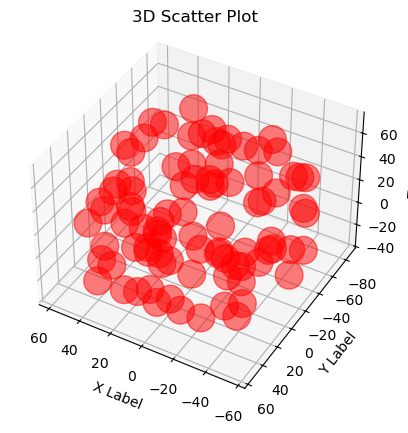

In [7]:
#%matplotlib qt
#%matplotlib inline  
# Define colors
colors = np.random.rand(90)
# Set a fixed size for all points (e.g., 20)
point_size = 20
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter(SpatialDistrib[:,0],SpatialDistrib[:,1],SpatialDistrib[:,2],c='red', s=400,alpha=0.5)

# Labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Rotate the plot: Set the elevation (elev) and azimuth (azim)
ax.view_init(elev=40, azim=120)


# Hide the grid
#ax.grid(False)

# Hide the axes
#ax.set_axis_off()

# Add title
ax.set_title('3D Scatter Plot')

### Second perspective

Text(0.5, 0.92, '3D Scatter Plot')

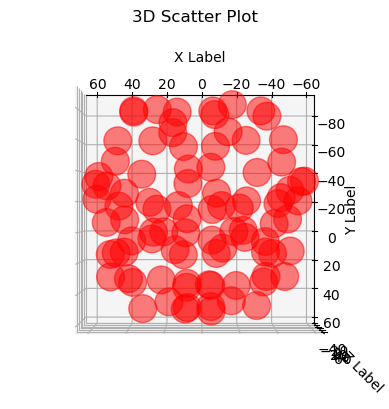

In [8]:
#%matplotlib qt
#%matplotlib inline  
# Define colors
colors = np.random.rand(90)
# Set a fixed size for all points (e.g., 20)
point_size = 20
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter(SpatialDistrib[:,0],SpatialDistrib[:,1],SpatialDistrib[:,2],c='red', s=400,alpha=0.5)

# Labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Rotate the plot: Set the elevation (elev) and azimuth (azim)
ax.view_init(elev=90, azim=90)


# Hide the grid
#ax.grid(False)

# Hide the axes
#ax.set_axis_off()

# Add title
ax.set_title('3D Scatter Plot')
#plt.show()

### Third perspective

In [16]:
veps.shape

(90, 90)

In [17]:
vep1 = veps[:,0]
vep2 = veps[:,1]
vep3 = veps[:,2]
vep4 = veps[:,3]
vep5 = veps[:,4]

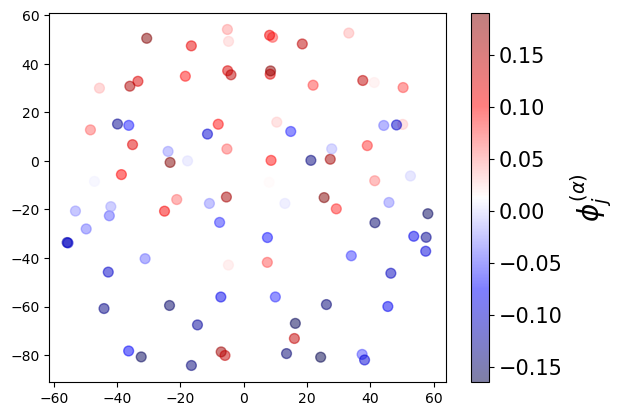

In [20]:
fig = plt.figure()
ax=plt.axes()
my_plot = ax.scatter(SpatialDistrib[:,0],SpatialDistrib[:,1],c=vep2, cmap='seismic',s=50,alpha=0.5)
cbar=plt.colorbar(my_plot)
cbar.set_label(r'$\phi_j^{(\alpha)}$', fontsize=20,fontname='Times New Roman')
cbar.ax.tick_params(labelsize=15)
plt.show()

Text(0.5, 0.92, '3D Scatter Plot')

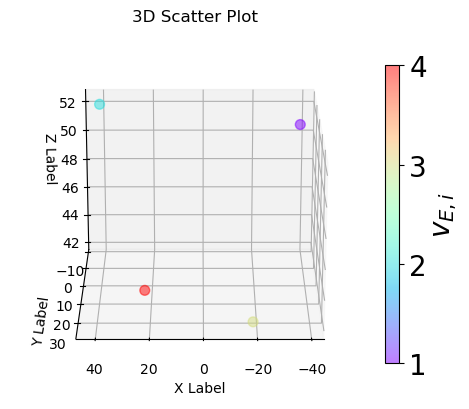

In [68]:
#%matplotlib qt
#%matplotlib inline  
# Define colors
colors = np.random.rand(90)
# Set a fixed size for all points (e.g., 20)
point_size = 20
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
#my_plot = ax.scatter(SpatialDistrib[0:5,0],SpatialDistrib[0:5,1],SpatialDistrib[0:5,2],c=SpatialDistrib[0:5,3], cmap='rainbow',s=50,alpha=0.5)
my_plot = ax.scatter(SpatialDistrib[0:4,0],SpatialDistrib[0:4,1],SpatialDistrib[0:4,2],c=SpatialDistrib[0:4,3], cmap='rainbow',s=50,alpha=0.5)

# Labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Rotate the plot: Set the elevation (elev) and azimuth (azim)
ax.view_init(elev=20, azim=90)

# Add a colorbar linked to the scatter plot
cbar = plt.colorbar(my_plot, ax=ax,fraction=0.03,pad=0.01)
cbar.set_label(r'$v_{E,i}$', fontsize=20,fontname='Times New Roman')
cbar.ax.tick_params(labelsize=20)

# Hide the grid
#ax.grid(False)

# Hide the axes
#ax.set_axis_off()

# Add title
ax.set_title('3D Scatter Plot')
#plt.show()

Text(0.5, 0.92, '3D Scatter Plot')

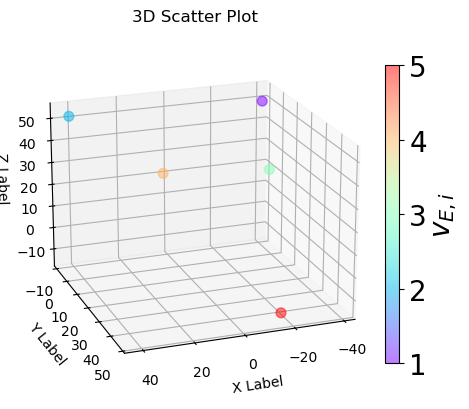

In [65]:
#%matplotlib qt
#%matplotlib inline  
# Define colors
colors = np.random.rand(90)
# Set a fixed size for all points (e.g., 20)
point_size = 20
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
my_plot = ax.scatter(SpatialDistrib[0:5,0],SpatialDistrib[0:5,1],SpatialDistrib[0:5,2],c=SpatialDistrib[0:5,3], cmap='rainbow',s=50,alpha=0.5)
#my_plot = ax.scatter(SpatialDistrib[0:4,0],SpatialDistrib[0:4,1],SpatialDistrib[0:4,2],c=SpatialDistrib[0:4,3], cmap='rainbow',s=50,alpha=0.5)

# Labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Rotate the plot: Set the elevation (elev) and azimuth (azim)
ax.view_init(elev=20, azim=70)

# Add a colorbar linked to the scatter plot
cbar = plt.colorbar(my_plot, ax=ax,fraction=0.03,pad=0.01)
cbar.set_label(r'$v_{E,i}$', fontsize=20,fontname='Times New Roman')
cbar.ax.tick_params(labelsize=20)

# Hide the grid
#ax.grid(False)

# Hide the axes
#ax.set_axis_off()

# Add title
ax.set_title('3D Scatter Plot')

## Structural connectivity matrix eigenvalues

In [12]:
data=np.load('NormalizedMatrix.npz')
norm_matrix = data['normalized_matrix']

### Compute vaps, veps

In [13]:
vaps,veps = np.linalg.eig(norm_matrix)

In [14]:
veps[:,0]

array([0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540926,
       0.10540926, 0.10540926, 0.10540926, 0.10540926, 0.10540

In [15]:
vaps

array([ 1.        ,  0.73934876,  0.65425786,  0.5687245 ,  0.49874633,
        0.44466697,  0.36865928,  0.33064698,  0.29606452,  0.28399787,
        0.27584778,  0.23503634,  0.18286062,  0.17066053,  0.16032548,
        0.14948684,  0.13790568,  0.12619627,  0.13413827,  0.10718836,
        0.09423369,  0.07918009, -0.25671502, -0.25449666, -0.25236642,
       -0.24750511,  0.06775315,  0.06271308,  0.05158073,  0.04273563,
        0.03816927,  0.03057755, -0.22756065, -0.22509675,  0.021659  ,
       -0.21465582, -0.20649652,  0.01226785,  0.00705985, -0.0014592 ,
       -0.00826669, -0.01232502, -0.19812416, -0.01598407, -0.0226029 ,
       -0.03079045, -0.03295201, -0.19072257, -0.1837642 , -0.18507469,
       -0.04306292, -0.04575105, -0.17584995, -0.17437931, -0.05128727,
       -0.05087574, -0.17078941, -0.17159854, -0.05701533, -0.06236927,
       -0.16538885, -0.06613111, -0.07111545, -0.1612432 , -0.07345495,
       -0.15752303, -0.08277615, -0.08551805, -0.09054885, -0.15

In [14]:
veps[:,1]

array([ 0.10052244,  0.05731921,  0.09412914,  0.07683769,  0.11709738,
        0.14736457,  0.12415688,  0.14552485,  0.18859965,  0.04061628,
        0.06567144,  0.03299011,  0.03806286,  0.07441957,  0.15839414,
        0.02015033,  0.00737128, -0.00267224,  0.06485019,  0.09541661,
        0.09504719,  0.03144959,  0.02994475,  0.07643877,  0.04804998,
        0.11019707,  0.12750272,  0.12482796,  0.1210631 ,  0.0833061 ,
        0.14870523,  0.18116189,  0.16426379,  0.01483552,  0.02329216,
        0.07241329,  0.10661253,  0.08660876,  0.06166025,  0.19007279,
        0.19078044,  0.16470615,  0.16939331,  0.14365519,  0.14487183,
       -0.14669501, -0.12584082, -0.16036714, -0.14189624, -0.16507486,
       -0.15693616, -0.04884325, -0.07753925, -0.09682542, -0.03790256,
       -0.05427487, -0.04266233, -0.14914921, -0.1520352 , -0.14504532,
       -0.10135888, -0.10795161, -0.1245557 , -0.13166025, -0.13687674,
       -0.08182878, -0.08487404, -0.0598786 , -0.0581954 , -0.06

In [31]:
np.ones(90)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [102]:
SpatialDistrib[:,0]

array([-38.65,  41.37, -18.45,  21.9 , -16.56,  18.49, -33.43,  37.59,
       -30.65,  33.18, -48.43,  50.2 , -45.58,  50.33, -35.98,  41.22,
       -47.16,  52.65,  -5.32,   8.62,  -8.06,  10.43,  -4.8 ,   9.1 ,
        -5.17,   8.16,  -5.08,   8.35, -35.13,  39.02,  -4.04,   8.46,
        -5.48,   8.02,  -4.85,   7.44, -25.03,  29.23, -21.17,  25.38,
       -23.27,  27.32,  -7.14,  15.99,  -5.93,  13.51, -14.62,  16.29,
       -16.54,  24.29, -32.39,  37.39, -36.36,  38.16, -31.16,  33.97,
       -42.46,  41.43, -23.45,  26.11, -42.8 ,  46.46, -55.79,  57.61,
       -44.14,  45.51,  -7.24,   9.98,  -7.63,   7.48, -11.46,  14.84,
       -23.91,  27.78, -17.75,  21.2 , -10.85,  13.  , -41.99,  45.86,
       -53.16,  58.15, -39.88,  48.25, -55.52,  57.47, -36.32,  44.22,
       -49.77,  53.69])

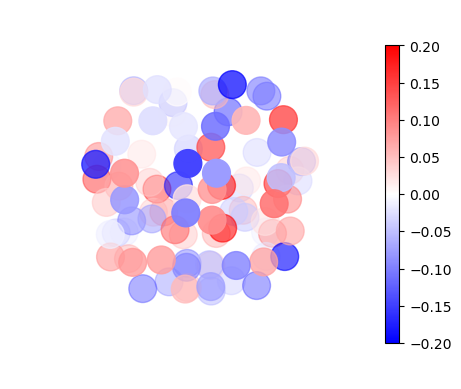

In [26]:
time = 925
#%matplotlib qt
%matplotlib inline  
# Define colors
colors = veps[:,50]
# Set a fixed size for all points (e.g., 20)
point_size = 400
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

my_plot = ax.scatter(SpatialDistrib[:, 0], SpatialDistrib[:, 1], SpatialDistrib[:, 2], 
                     c=colors, s=point_size, cmap='bwr', vmin=-0.2, vmax=0.2)
#my_plot = ax.scatter(SpatialDistrib[:, 0], np.transpose(SpatialDistrib[:, 1]), np.transpose(SpatialDistrib[:, 2]), 
                     #c=colors, s=point_size, cmap='bwr', vmin=-0.2, vmax=0.2)
# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.set_title(r'$\epsilon = $' + str(ParametersPop['eps']) + r', $I_{ext}^e = $' + str(ParametersPop['Iext_e']),fontsize=20,fontname='Times New Roman')

# Hide the grid and axes
ax.grid(False)
ax.set_axis_off()

# Add a colorbar linked to the scatter plot
colorbar = plt.colorbar(my_plot, ax=ax,fraction=0.03,pad=0.01)
cbar.set_label(r'$v_{E,i}$', fontsize=20,fontname='Times New Roman')
cbar.ax.tick_params(labelsize=20)

# Rotate the plot: Set the elevation (elev) and azimuth (azim)
ax.view_init(elev=90, azim=90)


# Hide the grid
#ax.grid(False)

# Hide the axes
#ax.set_axis_off()

## Integrate network perturbed

In [18]:
#Initial and final times of integration
t0 = 0
tf = 1000
#Discretization used for integration
h = 0.001
#Number of points to evaluate the time integration
N = int((tf-t0)/h)
time_eval = np.linspace(t0, tf, N)
#Number of variables and equations of the model
Nvariables = 6 #Number of variables of each population model
Npop = 90
Neq = Npop*Nvariables #Number of variables of the whole network

#Dictionary containing parameters of the model
ParametersPop = dict(tau_e = 8,
              tau_i = 8,
              tau_se=1,
              tau_si=5,
              nu_e = -5,
              nu_i = -5,
              Delta_e = 1,
              Delta_i = 1,
              Jee = 5,
              Jei = 13,
              Jii = 5,
              Jie = 13,
              Iext_i=0,
              Iext_e=5,
              eps=11)

Compute initial conditions for periodic orbit

In [19]:
status,x0_PO,T = InitCondPOHomogeneous_2(Nvariables,ParametersPop)

Exit status:  1
Exit message:  The solution converged.
Function evaluations:  12
Final residuals:  [-3.46944695e-17 -4.85722573e-17 -5.55111512e-16 -3.46944695e-17
 -1.04083409e-17 -1.33226763e-15 -5.20417043e-18]


In [20]:
re_0 = np.repeat(x0_PO[0],90)
ve_0 = np.repeat(x0_PO[1],90)
se_0 = np.repeat(x0_PO[2],90)
ri_0 = np.repeat(x0_PO[3],90)
vi_0 = np.repeat(x0_PO[4],90)
si_0 = np.repeat(x0_PO[5],90)
extended_x0_PO = np.hstack([re_0,ve_0,se_0,ri_0,vi_0,si_0])

In [21]:
#Initial condition on homogeneous to perturb
x0 = extended_x0_PO + np.random.normal(0, 0.01, Neq)#np.random.uniform(0, 0.1, Neq)

In [22]:
solPerturbedNetwork = solve_ivp(NextGenPopModel, [t0,tf], x0, t_eval=time_eval, method='RK45', rtol=1e-6, atol=1e-9,args=(norm_matrix, Nvariables, Npop, ParametersPop))

Grou variables in corresponding matrices

In [23]:
#Define indices
idx_ve = 1
idx_se = 2
idx_ri = 3
idx_vi = 4
idx_si = 5
#Define matrices of each variable of each population
r_e_matrix = solPerturbedNetwork.y[0:90,:]
v_e_matrix = solPerturbedNetwork.y[90*idx_ve:90*idx_se,:]
s_e_matrix = solPerturbedNetwork.y[90*idx_se:90*idx_ri,:]
r_i_matrix = solPerturbedNetwork.y[90*idx_ri:90*idx_vi,:]
v_i_matrix = solPerturbedNetwork.y[90*idx_vi:90*idx_si,:]
s_i_matrix = solPerturbedNetwork.y[90*idx_si:90*6,:]

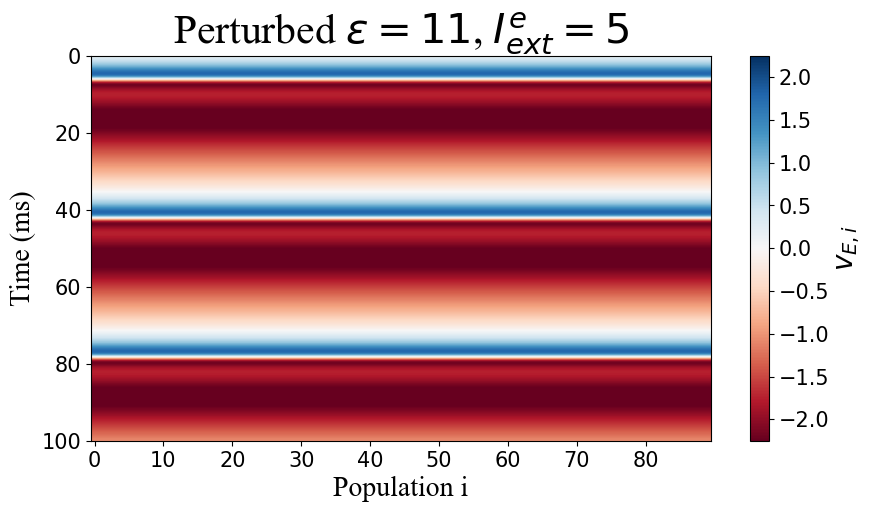

In [24]:
ms_idx = 100
fig2=plt.figure(figsize=(10,5))
plt.imshow(np.transpose(v_e_matrix[:,len(solPerturbedNetwork.t)-int(ms_idx/h):len(solPerturbedNetwork.t)]), cmap='RdBu', interpolation='nearest',vmin=-2.25, vmax=2.25)
#plt.imshow(np.transpose(v_e_matrix), cmap='RdBu', interpolation='nearest',vmin=-3, vmax=2)
plt.gca().set_aspect('auto')
cbar = plt.colorbar()
#edgesyticks = np.arange(len(solNetwork.t)+1,step=200/h)
#edgesylabels = (np.arange(len(solNetwork.t)+1,step=200/h)*h).astype(int)

edgesyticks = np.arange(ms_idx+1,step=20)/h
edgesylabels = (np.arange(ms_idx+1,step=20)).astype(int)
plt.xticks(fontsize=15)#,rotation=45)
plt.yticks(fontsize=15)
plt.yticks(ticks=edgesyticks,labels=edgesylabels,fontsize=15)
plt.xlabel('Population i',fontsize=20,fontname='Times New Roman')
plt.ylabel('Time (ms)',fontsize=20,fontname='Times New Roman')
plt.title(r'Perturbed $\epsilon = '+ f'{ParametersPop['eps']}$' + r', $I_{ext}^e = '+ f'{ParametersPop['Iext_e']}$',fontsize=30,fontname='Times New Roman')
cbar.set_label(r'$v_{E,i}$', fontsize=20,fontname='Times New Roman')
cbar.ax.tick_params(labelsize=15)
#plt.savefig('Definitive/Video__eps'+str(ParametersPop['eps'])+'Iext_e__'+str(ParametersPop['Iext_e'])+'.png',dpi=500,bbox_inches=Bbox([[0,-1],fig2.get_size_inches()]))

Plot brain associated to specific time

In [78]:
v_e_matrix[:,int(ms_idx/h)].shape

(90,)

In [79]:
v_e_matrix.shape

(90, 1000000)

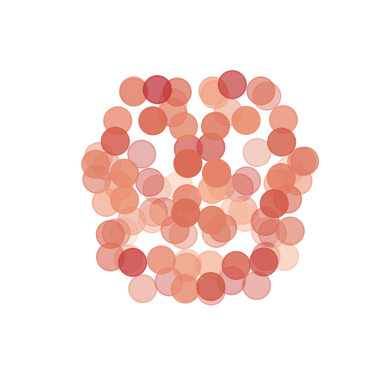

In [243]:
time = 925
#%matplotlib qt
%matplotlib inline  
# Define colors
colors = v_e_matrix[:,int(time/h)]
# Set a fixed size for all points (e.g., 20)
point_size = 400
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter(SpatialDistrib[:,0],SpatialDistrib[:,1],SpatialDistrib[:,2],c=colors, s=point_size,cmap='RdBu',vmin=-2.25, vmax=2.25)

# Labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Rotate the plot: Set the elevation (elev) and azimuth (azim)
ax.view_init(elev=90, azim=90)


# Hide the grid
ax.grid(False)

# Hide the axes
ax.set_axis_off()

# Add title
#ax.set_title('3D Scatter Plot')
#plt.show()

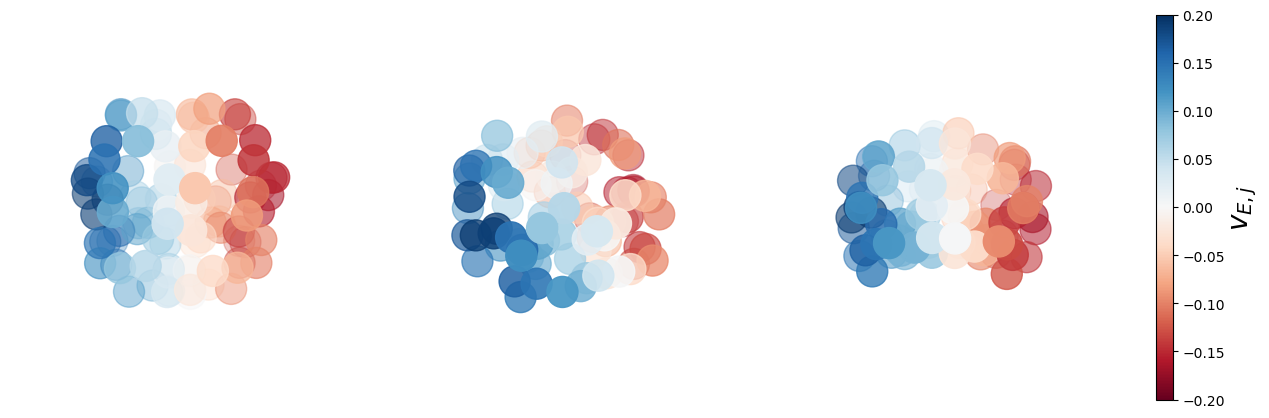

In [27]:
point_size = 500

fig = plt.figure(figsize=(15, 5))
# 3 subplots + 1 axis for colorbar
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)

view_angles = [(90, 90), (30, 60), (0, 90)]
axes = []
sc = None

for i in range(3):
    ax = fig.add_subplot(gs[i], projection='3d')
    sc = ax.scatter(
        SpatialDistribSort[:, 1], SpatialDistribSort[:, 2], SpatialDistribSort[:, 3],
        c=veps[:,1], s=point_size, cmap='RdBu', vmin=-0.2, vmax=0.2
    )
    ax.set_axis_off()
    ax.view_init(*view_angles[i])
    axes.append(ax)

# Add clean, dedicated colorbar
cbar_ax = fig.add_subplot(gs[3])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label(r'$v_{E,j}$',fontsize=20,fontname='Times New Roman')

plt.show()



plt.show()

## Make video

In [22]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

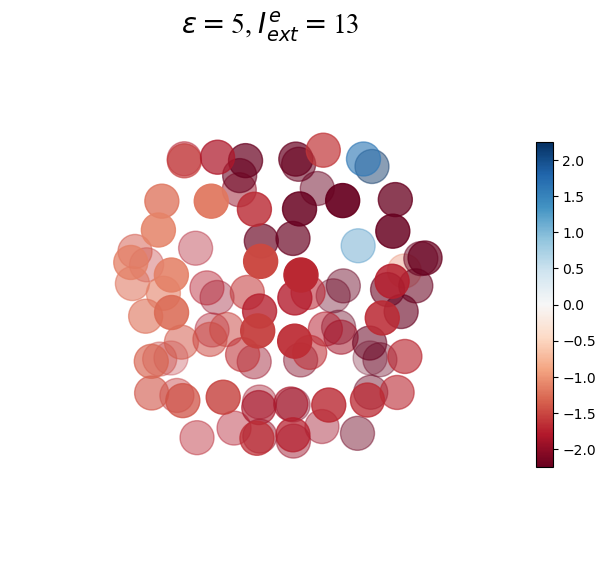

In [25]:
point_size = 600
# Create the figure and 3D axis
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot with initial color set to zero
colors = np.zeros(Npop)  # Initialize colors to zero. Initially we plot nothing
my_plot = ax.scatter(SpatialDistribSort[:, 1], SpatialDistribSort[:, 2], SpatialDistribSort[:, 3], 
                     c=colors, s=point_size, cmap='RdBu', vmin=-2.25, vmax=2.25)

# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title(r'$\epsilon = $' + str(ParametersPop['eps']) + r', $I_{ext}^e = $' + str(ParametersPop['Iext_e']),fontsize=20,fontname='Times New Roman')

# Hide the grid and axes
ax.grid(False)
ax.set_axis_off()

# Add a colorbar linked to the scatter plot
colorbar = plt.colorbar(my_plot, ax=ax,fraction=0.03,pad=0.01)
cbar.set_label(r'$v_{E,i}$', fontsize=20,fontname='Times New Roman')
cbar.ax.tick_params(labelsize=20)


# Init function: to set up the initial plot (called once)
def init():
    # Reset the color to initial state
    colors = np.zeros(Npop)  
    # Set initial color data
    my_plot.set_array(colors)  

    # Rotate the plot: Set the elevation (elev) and azimuth (azim)
    ax.view_init(elev=90, azim=90)
    
    # Return as a tuple for blitting (important)
    return my_plot,  

# Animation function: this is called sequentially for each frame
def animate(i):
    ms_idx = 60 #Show in the video the last 100 ms of integrations
    #time = 1000 + i  # Update time: Show in the video the last 100 ms of integrations
    
    # Get the colors for this frame (ensure it's a 1D array)
    #colors = v_e_matrix[:, len(solPerturbedNetwork.t)-int(ms_idx / h)+int(i/h)]  
    colors = v_e_matrix[:, len(solPerturbedNetwork.t)-int(ms_idx / h)+i]  

    # Update the colors in the plot
    my_plot.set_array(colors)
    
    return my_plot, 

# Create the animation
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=np.arange(int(40/h),step=50), interval=100, blit=True)

# Display the animation in the notebook
#HTML(anim.to_jshtml())  # Use to_jshtml() to render in the notebook
# Save the animation as a video (MP4)
#anim.save('Animation.mp4', writer='ffmpeg', fps=20)

# Save the animation as an AVI file
anim.save('Definitive/TestAnimation_eps_'+str(ParametersPop['eps'])+'Iext_e_'+str(ParametersPop['Iext_e'])+'.mp4', fps=15, extra_args=['-vcodec', 'libx264'])


# Show the animation (optional, depending on your environment)
plt.show()

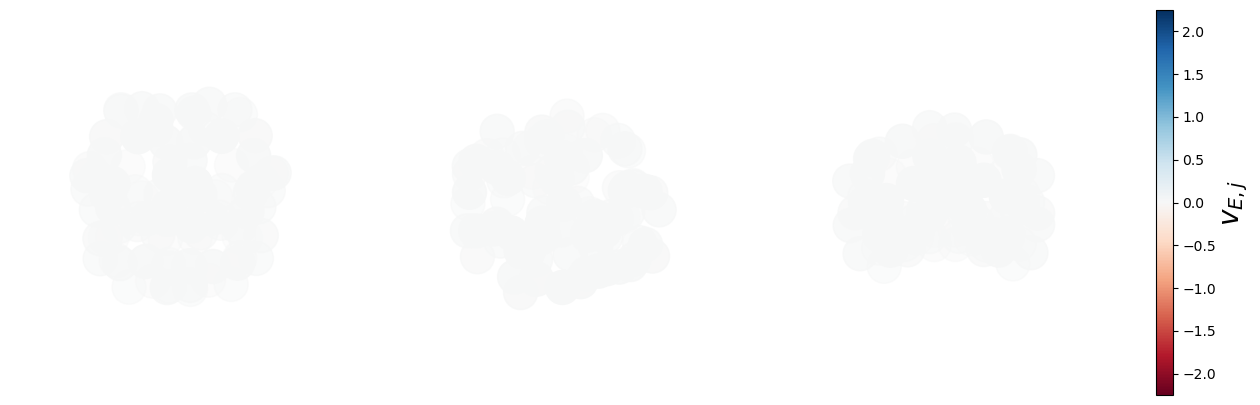

In [219]:
point_size = 600
# Create the figure and 3D axis
fig = plt.figure(figsize=(15, 5))
# 3 subplots + 1 axis for colorbar
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)

view_angles = [(90, 90), (30, 60), (0, 270)]
axes = []
sc = None

#Initial colors. Initialize colors to zero. Initially we plot nothing
colors = np.zeros(Npop)  

for i in range(3):
    ax = fig.add_subplot(gs[i], projection='3d')
    sc = ax.scatter(
        SpatialDistribSort[:, 1], SpatialDistribSort[:, 2], SpatialDistribSort[:, 3],
        c=colors, s=point_size, cmap='RdBu', vmin=-2.25, vmax=2.25
    )
    ax.set_axis_off()
    ax.view_init(*view_angles[i])
    axes.append(ax)

# Add clean, dedicated colorbar
cbar_ax = fig.add_subplot(gs[3])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label(r'$v_{E,j}$',fontsize=20,fontname='Times New Roman')

plt.show()

# Init function: to set up the initial plot (called once)
def init():
    # Reset the color to initial state
    colors = np.zeros(Npop)  
    # Set initial color data
    my_plot.set_array(colors)  

    # Rotate the plot: Set the elevation (elev) and azimuth (azim)
    #ax.view_init(elev=90, azim=90)
    
    # Return as a tuple for blitting (important)
    return my_plot,  

# Animation function: this is called sequentially for each frame
def animate(i):
    ms_idx = 60 #Show in the video the last 100 ms of integrations
    #time = 1000 + i  # Update time: Show in the video the last 100 ms of integrations
    
    # Get the colors for this frame (ensure it's a 1D array)
    #colors = v_e_matrix[:, len(solPerturbedNetwork.t)-int(ms_idx / h)+int(i/h)]  
    colors = v_e_matrix[:, len(solPerturbedNetwork.t)-int(ms_idx / h)+i]  

    # Update the colors in the plot
    my_plot.set_array(colors)
    
    return my_plot, 

# Create the animation
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=np.arange(int(40/h),step=50), interval=100, blit=True)

# Display the animation in the notebook
#HTML(anim.to_jshtml())  # Use to_jshtml() to render in the notebook
# Save the animation as a video (MP4)
#anim.save('Animation.mp4', writer='ffmpeg', fps=20)

# Save the animation as an AVI file
anim.save('Definitive/Animation_eps_'+str(ParametersPop['eps'])+'Iext_e_'+str(ParametersPop['Iext_e'])+'.mp4', fps=15, extra_args=['-vcodec', 'libx264'])


# Show the animation (optional, depending on your environment)
plt.show()

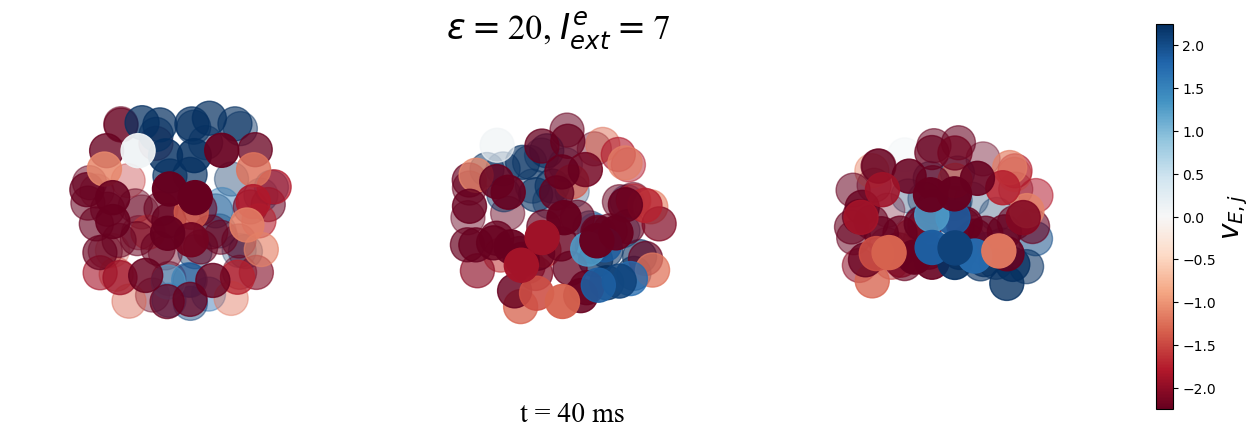

In [24]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
import numpy as np

# Setup figure and axes
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)
view_angles = [(90, 90), (30, 60), (0, 90)]
point_size = 600

colors = np.zeros(Npop)  # Initial colors
sc_list = []             # Store scatter objects for animation

for i in range(3):
    ax = fig.add_subplot(gs[i], projection='3d')
    sc = ax.scatter(
        SpatialDistribSort[:, 1], SpatialDistribSort[:, 2], SpatialDistribSort[:, 3],
        c=colors, s=point_size, cmap='RdBu', vmin=-2.25, vmax=2.25
    )
    ax.view_init(*view_angles[i])

    # Turn off axes cleanly
    ax.grid(False)
    ax.set_axis_off()

    if i==1:
        # Set title
        ax.set_title(r'$\epsilon = $' + str(ParametersPop['eps']) + r', $I_{ext}^e = $' + str(ParametersPop['Iext_e']),fontsize=25,fontname='Times New Roman')

    # Add text at the bottom center
    time_text = fig.text(0.5, 0.1, ' ',ha='center', va='center', fontsize=20, fontname='Times New Roman')
    sc_list.append(sc)

# Add colorbar
cbar_ax = fig.add_subplot(gs[3])
cbar = fig.colorbar(sc_list[0], cax=cbar_ax)
cbar.set_label(r'$v_{E,j}$', fontsize=20, fontname='Times New Roman')

# Init function
def init():
    time_text.set_text('t = 0') 
    for sc in sc_list:
        sc.set_array(np.zeros(Npop))  # Set to initial zero state
    return sc_list + [time_text]

# Animation update function
def animate(i):
    ms_idx = 60  # time window
    time_idx = len(solPerturbedNetwork.t) - int(ms_idx / h) + i
    color_frame = v_e_matrix[:, time_idx]

    for sc in sc_list:
        sc.set_array(color_frame)

    # Update the time text
    time_text.set_text(f't = {i*h:.0f} ms')

    return sc_list+ [time_text]

# Create animation
frame_count = int(ms_idx / h)
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=np.arange(int(40/h)+50,step=50), interval=1, blit=False)

# Save
anim.save('Definitive/Animation_eps_'+str(ParametersPop['eps'])+
          '_Iext_e_'+str(ParametersPop['Iext_e'])+'.mp4',
          fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()


In [48]:
v_e_matrix.shape

(90, 1000000)